STOCK MARKET ANALYSIS Q1+Q2 [QoQ]

In [11]:
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn.impute import SimpleImputer
import mplfinance as mf
from tqdm import tqdm
import requests
warnings.simplefilter("ignore")

In [12]:
#Ignore it while working on the existing file
ticker=['TCS.NS','MSFT']
start='01-01-2020'
end='30-06-2020'
fname=str('_'.join(ticker)+'_'+start+'_'+end+'.csv')
# idf=pdr.get_data_yahoo(ticker,start,end)
# idf.to_csv(fname)

PREPROCESSING DATA

In [13]:
df=pd.read_csv(fname,parse_dates=True,index_col=0)
df.reset_index(inplace=True)
if len(ticker)!=1:
    df=df.drop(index=[0,1,2])
else:
    df=df.drop(index=[0,1])
df=df.rename(columns={'Attributes':'Date'})
df.set_index('Date',inplace=True)
df.index=pd.to_datetime(df.index)

In [14]:
def nanfinder():
    lna=[]
    for i in df.columns:
        if df[i].isna().sum():
            lna.append(i)
    count=len(lna) #No of cols that have NaN
    return (lna,count)
nanfinder()

(['Adj Close',
  'Adj Close.1',
  'Close',
  'Close.1',
  'High',
  'High.1',
  'Low',
  'Low.1',
  'Open',
  'Open.1',
  'Volume',
  'Volume.1'],
 12)

In [15]:
lna, count=nanfinder()[0], nanfinder()[1]
imputer = SimpleImputer(missing_values = np.nan,strategy ='median')
for i in range(count):
    imputer=imputer.fit(df[[lna[i]]])
    df[lna[i]]=imputer.transform(df[[lna[i]]])
nanfinder()

([], 0)

WORKING ON THE FINISHED DATA

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

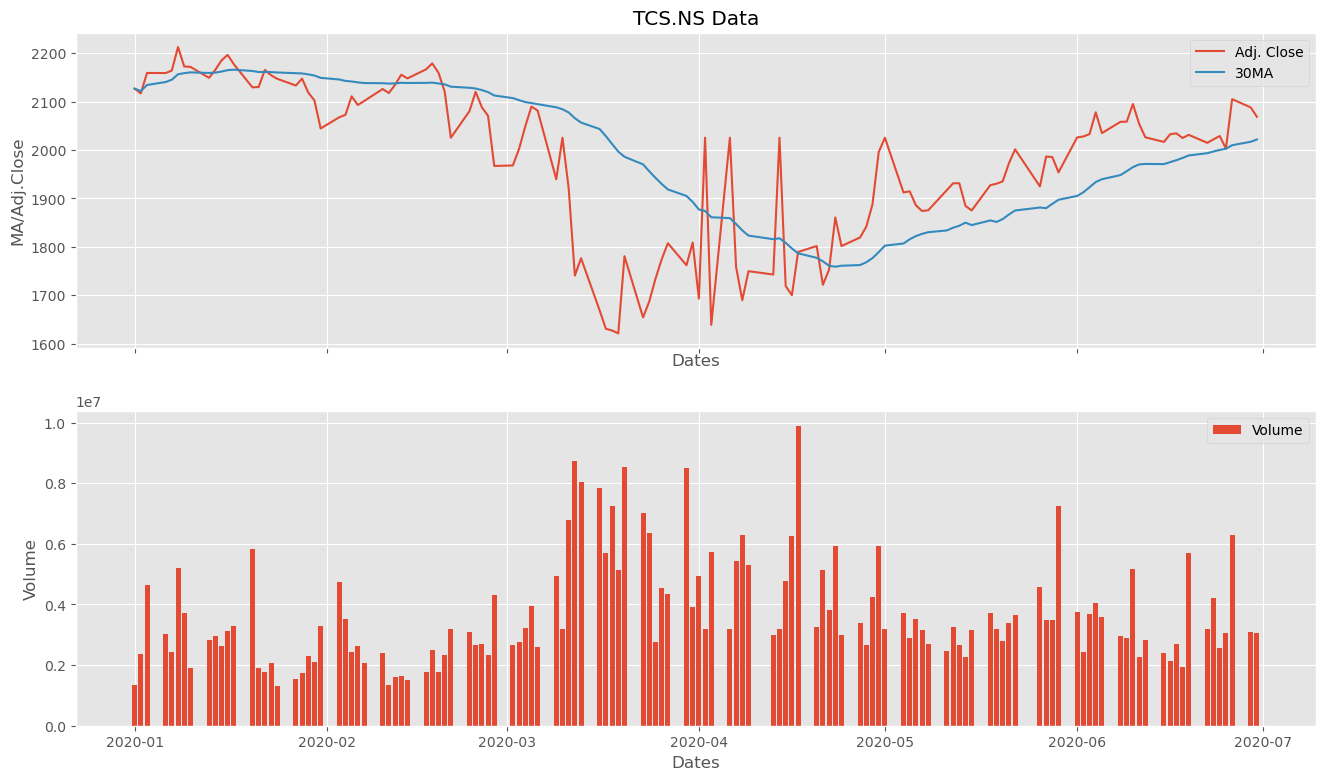

 50%|██████████████████████████████████████████                                          | 1/2 [00:02<00:02,  2.18s/it]

<Figure size 640x480 with 0 Axes>

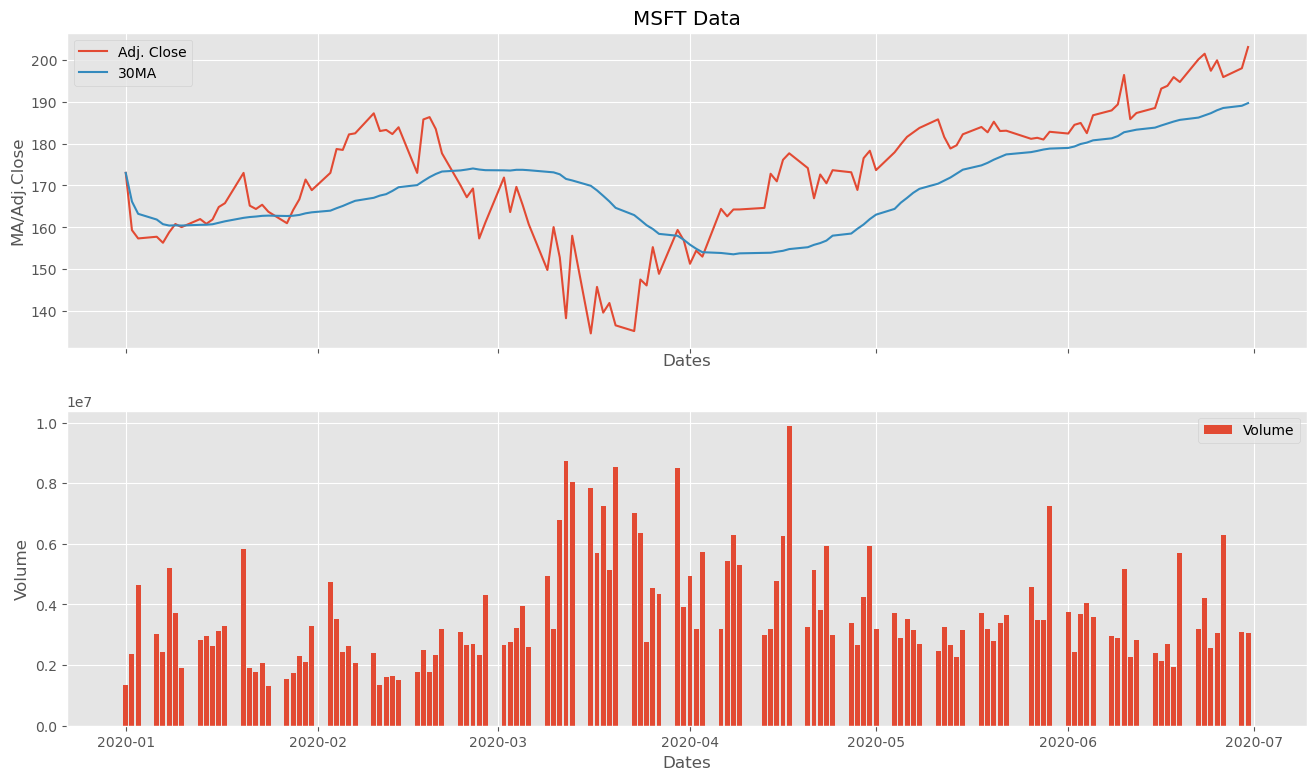

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


In [16]:
## SMA
for t in tqdm(range(len(ticker))):
    if t != 0:
        _t = str(t)
        _adj = str('Adj Close' + "." + _t)
    else:
        _adj = str('Adj Close')
    df['30ma'] = df[_adj].rolling(window=30, min_periods=0).mean()
    plt.subplots_adjust(hspace=0.3)
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16, 9))
    ax1.plot(df.index, df[_adj])
    ax1.plot(df.index, df['30ma'])
    ax1.set_xlabel("Dates")
    ax1.set_ylabel("MA/Adj.Close")
    ax2.bar(df.index, df['Volume'])
    ax2.set_xlabel("Dates")
    ax2.set_ylabel("Volume")
    ax1.legend(['Adj. Close', '30MA'])
    ax2.legend(['Volume'])
    tit = str(ticker[t] + ' Data')
    ax1.set_title(tit)
    plt.show()

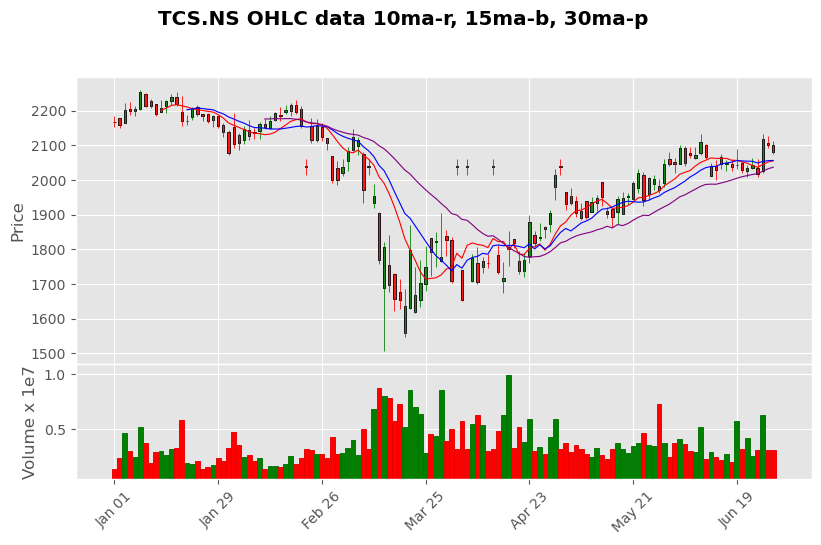

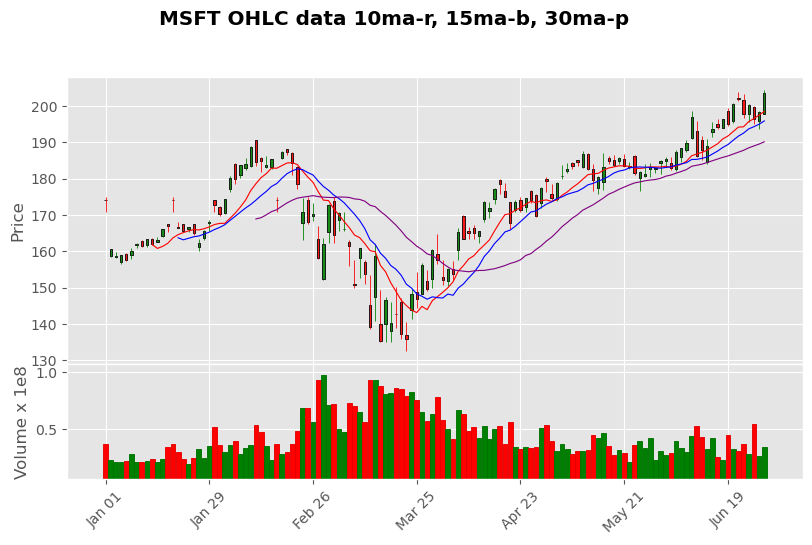

In [17]:
## Candlestick_OHLC
# mf.available_styles()
for t in range(len(ticker)):
    if t != 0:
        _t = str(t)
        _open = str('Open' + "." + _t)
        _high = str('High' + "." + _t)
        _low = str('Low' + "." + _t)
        _close = str('Close' + "." + _t)
        _volume = str('Volume' + "." + _t)
    else:
        _open = 'Open'
        _high = "High"
        _low = "Low"
        _close = "Close"
        _volume = "Volume"
    df_ohlc = df[[_open, _high, _low, _close, _volume]].values.tolist()
    ohlc = [[df.index[i]] + df_ohlc[i] for i in range(len(df))]
    ohlc = pd.DataFrame(
        ohlc, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    if type(ohlc['Open'][0]) is not float:
        for i in ohlc.columns:
            if i != 'Date':
                ohlc[i] = pd.to_numeric(ohlc[i], downcast="float")
    ohlc.set_index('Date', inplace=True)
    config = dict(type='candle',
                  mav=(10, 15, 30),
                  volume=True,
                  figratio=(16, 9))
    mc = mf.make_marketcolors(up='g',
                              down='r',
                              volume='inherit',
                              wick={
                                  'up': 'green',
                                  'down': 'red'
                              })
    s = mf.make_mpf_style(base_mpl_style="ggplot",
                          mavcolors=['red', 'blue', 'purple'],
                          marketcolors=mc)
    tit = ticker[t] + ' OHLC data' + ' 10ma-r, 15ma-b, 30ma-p'
    mf.plot(ohlc[:], **config, style=s, title=tit, no_xgaps=True)

100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 4265.35it/s]


Invest in ['MSFT'] as it got 3-ok pass


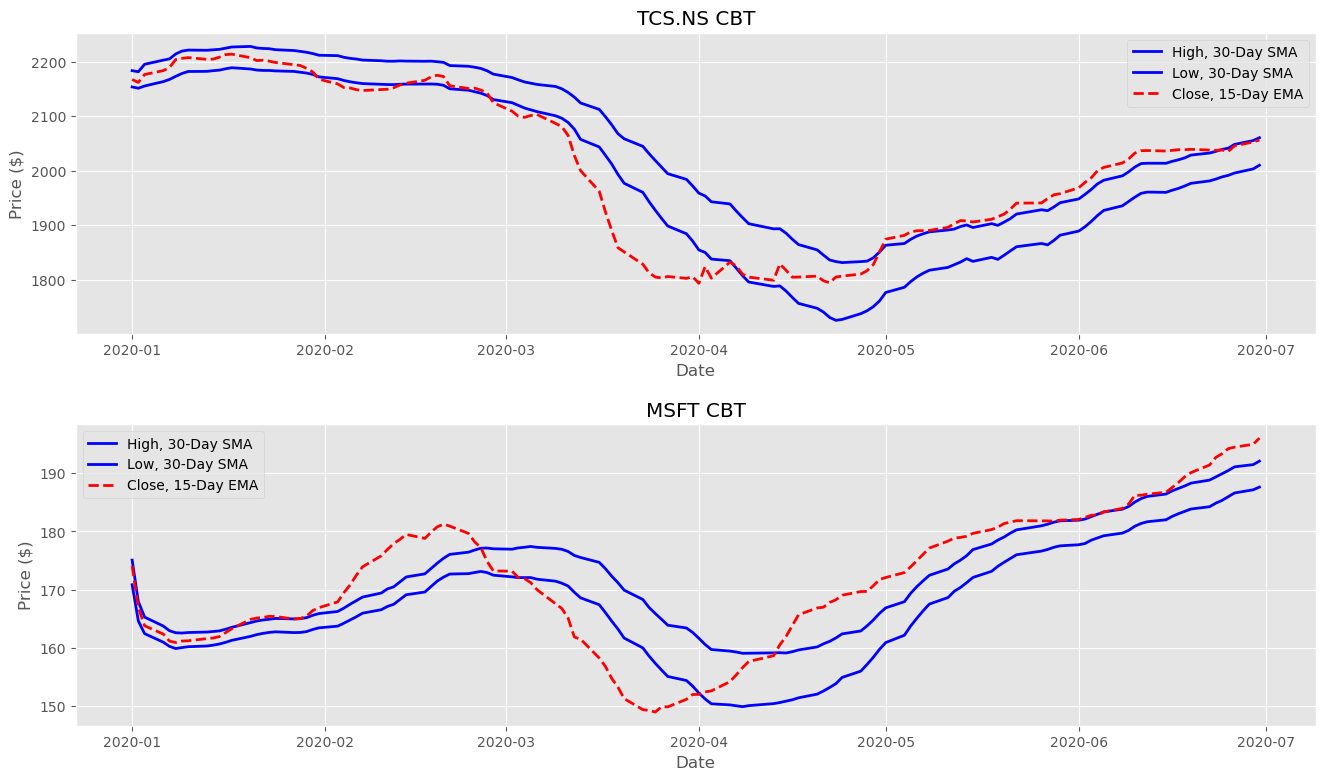

In [18]:
## CAMELBACK TECHNIQUE
fig, ax = plt.subplots(len(ticker), figsize=(16, 9))
plt.subplots_adjust(hspace=0.3)
oks = []
def QI(df_cbt):
    rs = len(df_cbt) - 1
    re = rs - 60
    rsl = re + 30
    ok1, ok2, ok3 = 0, 0, 0
    for i in tqdm(range(rs, re, -1)):  #for last 2 months [ok1]
        if df_cbt['ema15'][i] >= df_cbt['hsma30'][i]:
            ok1 = ok1 + 1
        if i in range(rsl, rs):  #for last 1 month [ok2]
            if df_cbt['ema15'][i] >= df_cbt['hsma30'][i]:
                ok2 = ok2 + 1
    for i in tqdm(range(len(df_cbt))):
        if df_cbt['ema15'][i] >= df_cbt['hsma30'][i]:  #for total duration [ok3]
            ok3 = ok3 + 1
    if ok1 > 45 and ok2 in range(23, 31) and ok3 > int(len(df_cbt) / 2):
        return 1
    else:
        return (ok1, ok2, ok3)


for t in range(len(ticker)):
    if t != 0:
        _t = str(t)
        _open = str('Open' + "." + _t)
        _high = str('High' + "." + _t)
        _low = str('Low' + "." + _t)
        _close = str('Close' + "." + _t)
        _volume = str('Volume' + "." + _t)
    else:
        _open = 'Open'
        _high = "High"
        _low = "Low"
        _close = "Close"
        _volume = "Volume"
    hsma30 = df[_high].rolling(30, min_periods=0).mean()
    lsma30 = df[_low].rolling(30, min_periods=0).mean()
    ema15 = df[_close].ewm(span=15, min_periods=0).mean()
    if len(ticker) != 1:
        ax[t].plot(hsma30[:],
                   color='blue',
                   linewidth=2,
                   label='High, 30-Day SMA')
        ax[t].plot(lsma30[:],
                   color='blue',
                   linewidth=2,
                   label='Low, 30-Day SMA')
        ax[t].plot(ema15[:],
                   color='red',
                   linestyle='--',
                   linewidth=2,
                   label='Close, 15-Day EMA')
        ax[t].set_xlabel('Date')
        ax[t].set_ylabel('Price ($)')
        ax[t].legend()
        tit = ticker[t] + ' CBT'
        ax[t].set_title(tit)
    else:
        ax.plot(hsma30[:], color='blue', linewidth=2, label='High, 30-Day SMA')
        ax.plot(lsma30[:], color='blue', linewidth=2, label='Low, 30-Day SMA')
        ax.plot(ema15[:],
                color='red',
                linestyle='--',
                linewidth=2,
                label='Close, 15-Day EMA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price (Rs.)')
        ax.legend()
        tit = ticker[t] + ' CBT'
        ax.set_title(tit)
    df_cbt = pd.DataFrame(zip(df.index, hsma30, ema15),
                          columns=['Date', 'hsma30', 'ema15'])
    if (QI(df_cbt) == 1):
        oks.append(ticker[t])
if len(oks) != 0:
    print('Invest in {} as it got 3-ok pass'.format(oks))
else:
    print('Don\'t invest in any of these.')

In [19]:
## STD
stds = {}
for t in tqdm(range(len(ticker))):
    if t != 0:
        _t = str(t)
        col = str('Adj Close' + "." + _t)
    else:
        col = 'Adj Close'
    x = df[col].std()
    stds[ticker[t]] = x
stds = sorted(stds.items(), key=lambda x: x[1])
risk = {}
for i in range(len(stds)):
    risk[stds[i][0]]=i
print(risk)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 399.91it/s]

{'MSFT': 0, 'TCS.NS': 1}


In [20]:
## Scraping
r=requests.get("https://www.fpi.nsdl.co.in/web/Reports/Latest.aspx")

0:g
1:e
2:e
3:k
